In [243]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr, spearmanr

# Font settings
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False  # Prevent minus sign issues


orgDf = pd.read_csv('../../datasets/credit_card_fraud_dataset.csv')
orgDf.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


제안 2: 이상 거래 탐지
- 문제 정의:
    +  거래 데이터(Amount, TransactionType, Location, IsFraud)를 바탕으로 이상 거래를 탐지하고, 거래 사기 가능성을 예측합니다.
- 목표:
    + 거래 금액의 분포 및 이상치 탐색
    + 거래 유형별 사기 발생률 비교
    + 사기 거래가 자주 발생하는 지역 및 시간대 식별
-   배경:
    + 이상 거래를 조기에 탐지함으로써 사기 방지 시스템을 강화하고, 금융 손실을 줄일 수 있습니다.

In [244]:
orgDf.info(), orgDf.index, orgDf.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


(None,
 RangeIndex(start=0, stop=100000, step=1),
        TransactionID         Amount     MerchantID        IsFraud
 count  100000.000000  100000.000000  100000.000000  100000.000000
 mean    50000.500000    2497.092666     501.676070       0.010000
 std     28867.657797    1442.415999     288.715868       0.099499
 min         1.000000       1.050000       1.000000       0.000000
 25%     25000.750000    1247.955000     252.000000       0.000000
 50%     50000.500000    2496.500000     503.000000       0.000000
 75%     75000.250000    3743.592500     753.000000       0.000000
 max    100000.000000    4999.770000    1000.000000       1.000000)

In [245]:
orgDf['Amount'].describe()

count    100000.000000
mean       2497.092666
std        1442.415999
min           1.050000
25%        1247.955000
50%        2496.500000
75%        3743.592500
max        4999.770000
Name: Amount, dtype: float64

In [246]:
len(orgDf['MerchantID'].value_counts()), orgDf['MerchantID'].value_counts()

(1000,
 MerchantID
 461    149
 188    134
 192    129
 517    128
 820    126
       ... 
 119     75
 936     74
 968     73
 635     71
 512     69
 Name: count, Length: 1000, dtype: int64)

In [247]:
orgDf['IsFraud'].value_counts()

IsFraud
0    99000
1     1000
Name: count, dtype: int64

In [248]:
orgDf['Location'].value_counts() 

Location
Chicago         10193
San Diego       10111
Dallas          10076
San Antonio     10062
New York         9993
Houston          9991
Phoenix          9960
Los Angeles      9936
Philadelphia     9873
San Jose         9805
Name: count, dtype: int64

In [249]:
fraud = orgDf[orgDf['IsFraud'] == 1]


In [250]:
fraud['Location'].value_counts()

Location
New York        116
San Diego       115
Houston         105
Phoenix          99
Dallas           99
San Antonio      99
Chicago          95
Los Angeles      95
Philadelphia     90
San Jose         87
Name: count, dtype: int64

In [251]:
rateOfPurchase = (orgDf['Location'].value_counts()) / 100000
rateOfPurchase

Location
Chicago         0.10193
San Diego       0.10111
Dallas          0.10076
San Antonio     0.10062
New York        0.09993
Houston         0.09991
Phoenix         0.09960
Los Angeles     0.09936
Philadelphia    0.09873
San Jose        0.09805
Name: count, dtype: float64

In [252]:
rateOfFraudByLoc = (fraud['Location'].value_counts()) / 1000
rateOfFraudByLoc

Location
New York        0.116
San Diego       0.115
Houston         0.105
Phoenix         0.099
Dallas          0.099
San Antonio     0.099
Chicago         0.095
Los Angeles     0.095
Philadelphia    0.090
San Jose        0.087
Name: count, dtype: float64

In [253]:
orgDf['TransactionDate'].info, orgDf['TransactionDate'].describe(), orgDf['TransactionDate'].value_counts(), orgDf['TransactionDate'].index

(<bound method Series.info of 0        2024-04-03 14:15:35.462794
 1        2024-03-19 13:20:35.462824
 2        2024-01-08 10:08:35.462834
 3        2024-04-13 23:50:35.462850
 4        2024-07-12 18:51:35.462858
                     ...            
 99995    2024-06-07 00:57:36.027591
 99996    2023-10-22 23:12:36.027594
 99997    2024-05-31 19:27:36.027597
 99998    2024-10-18 09:43:36.027601
 99999    2024-03-05 19:41:36.027606
 Name: TransactionDate, Length: 100000, dtype: object>,
 count                         100000
 unique                        100000
 top       2023-10-30 06:53:36.027441
 freq                               1
 Name: TransactionDate, dtype: object,
 TransactionDate
 2023-10-30 06:53:36.027441    1
 2024-07-11 10:55:36.027444    1
 2023-11-23 08:37:36.027449    1
 2024-09-07 05:03:36.027453    1
 2024-03-29 11:33:36.027457    1
                              ..
 2024-04-13 23:50:35.462850    1
 2024-07-12 18:51:35.462858    1
 2024-08-30 01:52:35.462867    1
 20

### 거래 금액의 분포 및 이상치 탐색

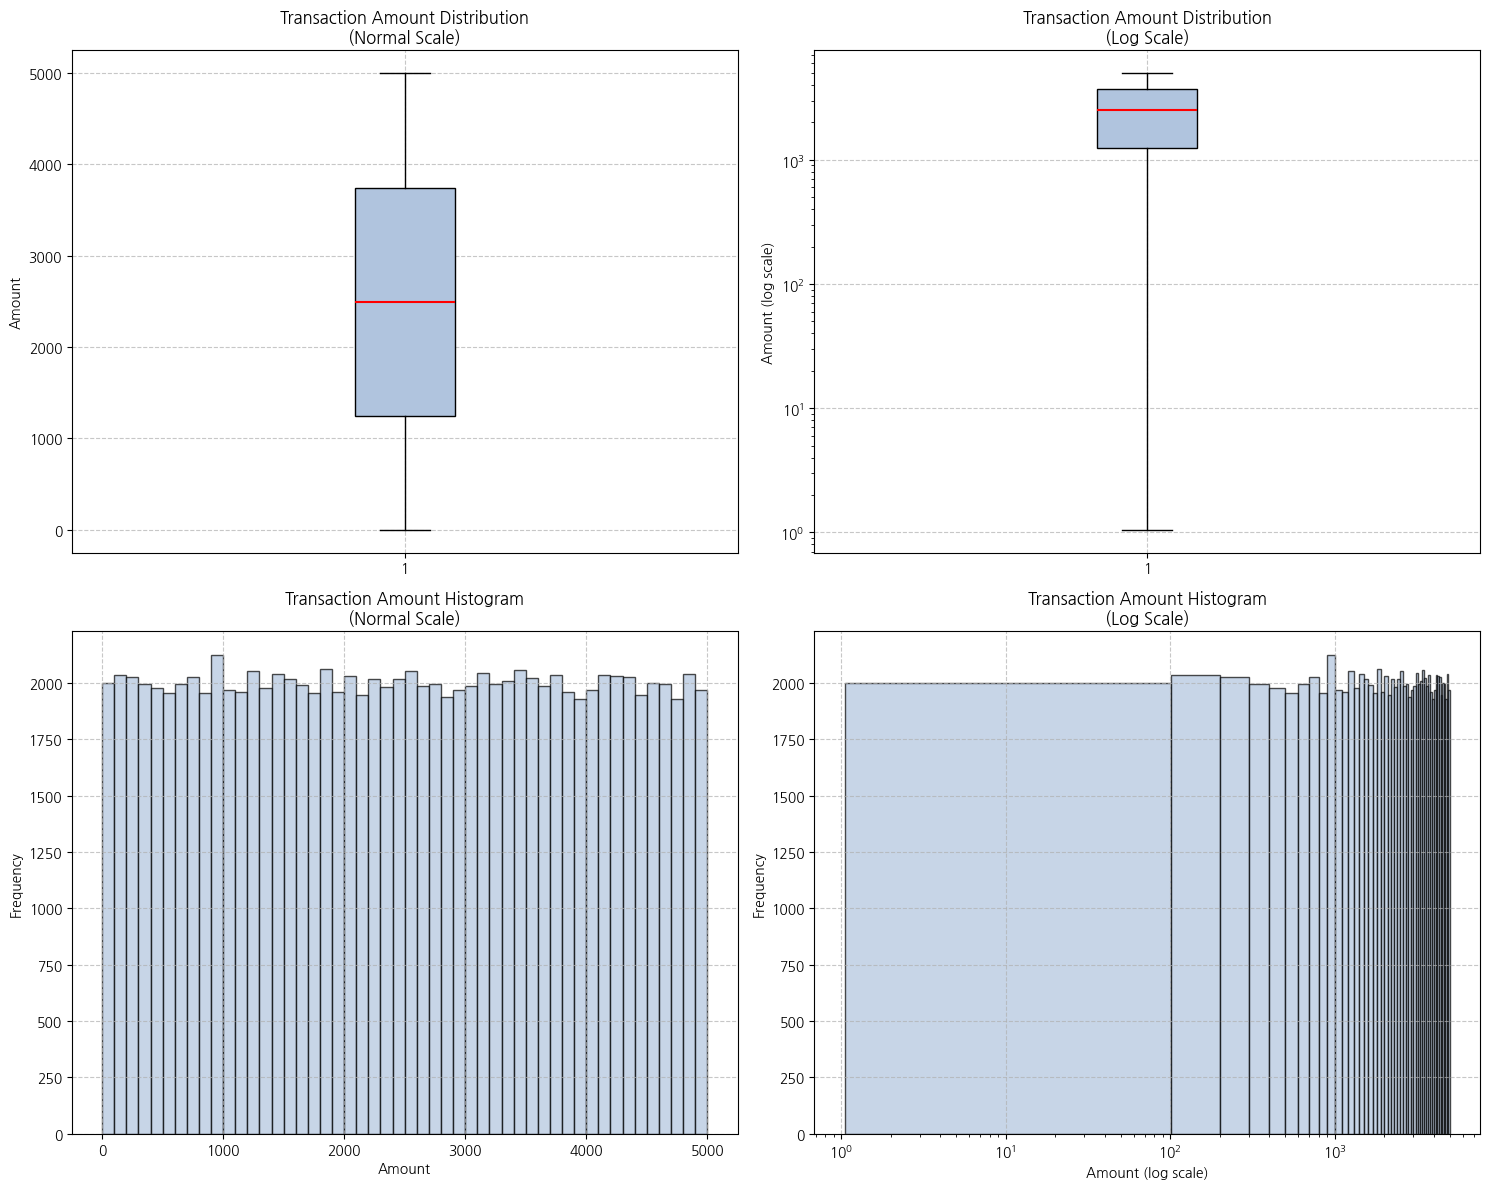

/tmp/ipykernel_49625/1465083141.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(data, labels=['Normal', 'Fraud'], patch_artist=True)
/tmp/ipykernel_49625/1465083141.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(data, labels=['Normal', 'Fraud'], patch_artist=True)


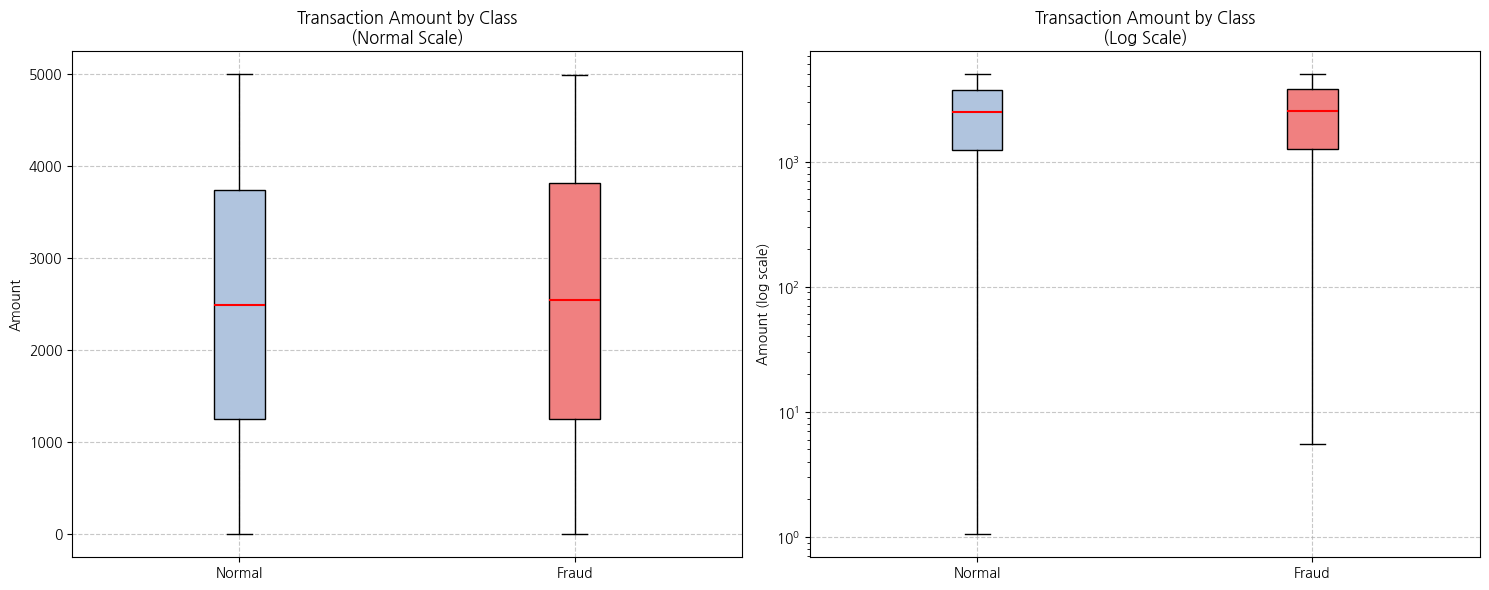


=== Amount Statistics by Transaction Class ===

Normal Transactions:
count    99000.00
mean      2496.89
std       1442.26
min          1.05
25%       1247.96
50%       2495.61
75%       3742.86
max       4999.77
Name: Amount, dtype: float64

Fraudulent Transactions:
count    1000.00
mean     2517.16
std      1458.64
min         5.56
25%      1249.28
50%      2543.43
75%      3813.85
max      4985.88
Name: Amount, dtype: float64


In [254]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Transaction Amount Distribution Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Box Plot (Normal Scale)
bp = ax1.boxplot(orgDf['Amount'], patch_artist=True)
ax1.set_title('Transaction Amount Distribution\n(Normal Scale)', fontsize=12)
ax1.set_ylabel('Amount')
ax1.grid(True, linestyle='--', alpha=0.7)
plt.setp(bp['boxes'], color='black', facecolor='lightsteelblue')
plt.setp(bp['medians'], color='red', linewidth=1.5)
plt.setp(bp['whiskers'], color='black', linestyle='-')
plt.setp(bp['fliers'], marker='o', markerfacecolor='gray', alpha=0.5)

# Box Plot (Log Scale)
bp = ax2.boxplot(orgDf['Amount'], patch_artist=True)
ax2.set_yscale('log')
ax2.set_title('Transaction Amount Distribution\n(Log Scale)', fontsize=12)
ax2.set_ylabel('Amount (log scale)')
ax2.grid(True, linestyle='--', alpha=0.7)
plt.setp(bp['boxes'], color='black', facecolor='lightsteelblue')
plt.setp(bp['medians'], color='red', linewidth=1.5)
plt.setp(bp['whiskers'], color='black', linestyle='-')
plt.setp(bp['fliers'], marker='o', markerfacecolor='gray', alpha=0.5)

# Histogram (Normal Scale)
n, bins, patches = ax3.hist(orgDf['Amount'], bins=50, 
                           facecolor='lightsteelblue', 
                           edgecolor='black', 
                           alpha=0.7)
ax3.set_title('Transaction Amount Histogram\n(Normal Scale)', fontsize=12)
ax3.set_xlabel('Amount')
ax3.set_ylabel('Frequency')
ax3.grid(True, linestyle='--', alpha=0.7)

# Histogram (Log Scale)
n, bins, patches = ax4.hist(orgDf['Amount'], bins=50, 
                           facecolor='lightsteelblue', 
                           edgecolor='black', 
                           alpha=0.7)
ax4.set_xscale('log')
ax4.set_title('Transaction Amount Histogram\n(Log Scale)', fontsize=12)
ax4.set_xlabel('Amount (log scale)')
ax4.set_ylabel('Frequency')
ax4.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 2. Fraud vs Normal Transaction Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box Plot Comparison (Normal and Log Scale)
normal_amounts = orgDf[orgDf['IsFraud']==0]['Amount']
fraud_amounts = orgDf[orgDf['IsFraud']==1]['Amount']

# Normal Scale
data = [normal_amounts, fraud_amounts]
bp1 = ax1.boxplot(data, labels=['Normal', 'Fraud'], patch_artist=True)
ax1.set_title('Transaction Amount by Class\n(Normal Scale)', fontsize=12)
ax1.set_ylabel('Amount')
ax1.grid(True, linestyle='--', alpha=0.7)
plt.setp(bp1['boxes'][0], facecolor='lightsteelblue')
plt.setp(bp1['boxes'][1], facecolor='lightcoral')
plt.setp(bp1['medians'], color='red', linewidth=1.5)

# Log Scale
bp2 = ax2.boxplot(data, labels=['Normal', 'Fraud'], patch_artist=True)
ax2.set_yscale('log')
ax2.set_title('Transaction Amount by Class\n(Log Scale)', fontsize=12)
ax2.set_ylabel('Amount (log scale)')
ax2.grid(True, linestyle='--', alpha=0.7)
plt.setp(bp2['boxes'][0], facecolor='lightsteelblue')
plt.setp(bp2['boxes'][1], facecolor='lightcoral')
plt.setp(bp2['medians'], color='red', linewidth=1.5)

plt.tight_layout()
plt.show()

# Print statistics
print("\n=== Amount Statistics by Transaction Class ===")
print("\nNormal Transactions:")
print(normal_amounts.describe().round(2))
print("\nFraudulent Transactions:")
print(fraud_amounts.describe().round(2))


In [255]:
'''Normal Scale (선형 스케일)
데이터를 있는 그대로의 값으로 표현
일정한 간격으로 눈금이 표시됨 (예: 0, 100, 200, 300, ...)
장점: 직관적이고 실제 값을 바로 파악 가능
단점: 값의 범위가 매우 클 경우 작은 값들의 차이를 구분하기 어려움
Log Scale (로그 스케일)
데이터를 로그 변환하여 표현
지수적으로 눈금이 증가 (예: 1, 10, 100, 1000, ...)
장점:
매우 큰 값과 작은 값을 한 그래프에서 효과적으로 표현 가능
상대적 변화(비율)를 쉽게 파악 가능
단점: 실제 값을 직접적으로 읽기 어려움'''

'Normal Scale (선형 스케일)\n데이터를 있는 그대로의 값으로 표현\n일정한 간격으로 눈금이 표시됨 (예: 0, 100, 200, 300, ...)\n장점: 직관적이고 실제 값을 바로 파악 가능\n단점: 값의 범위가 매우 클 경우 작은 값들의 차이를 구분하기 어려움\nLog Scale (로그 스케일)\n데이터를 로그 변환하여 표현\n지수적으로 눈금이 증가 (예: 1, 10, 100, 1000, ...)\n장점:\n매우 큰 값과 작은 값을 한 그래프에서 효과적으로 표현 가능\n상대적 변화(비율)를 쉽게 파악 가능\n단점: 실제 값을 직접적으로 읽기 어려움'

### 거래 유형별 사기 발생률 비교


=== Top 10 Merchant Types with Most Fraud Transactions ===

Merchant Type | Number of Frauds
----------------------------------------
MerchantID 156: 5
MerchantID 583: 5
MerchantID 640: 5
MerchantID 958: 5
MerchantID 276: 4
MerchantID 216: 4
MerchantID 989: 4
MerchantID 747: 4
MerchantID 568: 4
MerchantID 659: 4


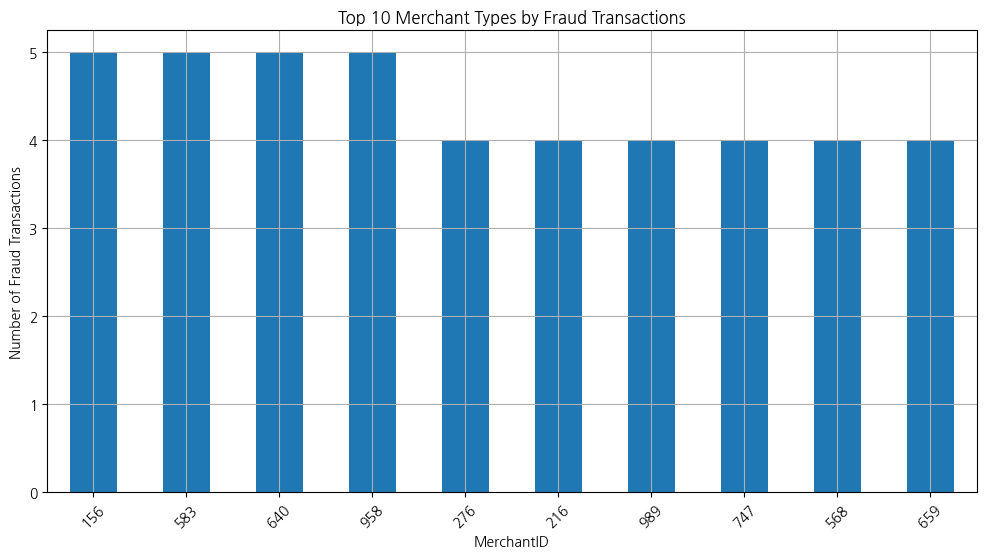


=== Top 10 Merchant Types by Fraud Rate ===

Merchant Type | Fraud Rate (%)
----------------------------------------
MerchantID 640: 5.81%
MerchantID 156: 4.85%
MerchantID 583: 4.72%
MerchantID 659: 4.55%
MerchantID 939: 4.4%
MerchantID 436: 4.17%
MerchantID 568: 4.12%
MerchantID 968: 4.11%
MerchantID 401: 4.08%
MerchantID 989: 4.04%


In [256]:
# MerchantID별 사기 거래 건수 계산
fraudByMerchant = fraud['MerchantID'].value_counts()

# 상위 10개 사기 다발 거래 유형 출력
print("\n=== Top 10 Merchant Types with Most Fraud Transactions ===")
print("\nMerchant Type | Number of Frauds")
print("-" * 40)
for merchant, count in fraudByMerchant.head(10).items():
    print(f"MerchantID {merchant}: {count}")

# 시각화
plt.figure(figsize=(12, 6))
fraudByMerchant.head(10).plot(kind='bar')
plt.title('Top 10 Merchant Types by Fraud Transactions')
plt.xlabel('MerchantID')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 전체 거래 대비 사기 거래 비율 계산
total_by_merchant = orgDf['MerchantID'].value_counts()
fraud_rate_by_merchant = (fraudByMerchant / total_by_merchant * 100).round(2)

print("\n=== Top 10 Merchant Types by Fraud Rate ===")
print("\nMerchant Type | Fraud Rate (%)")
print("-" * 40)
for merchant, rate in fraud_rate_by_merchant.sort_values(ascending=False).head(10).items():
    print(f"MerchantID {merchant}: {rate}%")


### 사기 거래가 자주 발생하는 지역 및 시간대 식별

In [257]:
# TransactionDate에서 시간 추출 (시간별 분석)
fraud['Hour'] = pd.to_datetime(fraud['TransactionDate']).dt.hour

# 시간별 사기 거래 건수 계산
fraudByHour = fraud['Hour'].value_counts().sort_index()

# 가장 많은 사기가 발생한 시간 찾기
peakHour = fraudByHour.idxmax()
peakCount = fraudByHour.max()
print(f"사기 거래가 가장 많이 발생한 시간: {peakHour}시")
print(f"해당 시간대의 사기 거래 건수: {peakCount}건")

# 요일별 분석
fraud['DayOfWeek'] = pd.to_datetime(fraud['TransactionDate']).dt.day_name()
fraudByDay = fraud['DayOfWeek'].value_counts()

print("\n요일별 사기 거래 건수:")
print(fraudByDay)

# 월별 분석
fraud['Month'] = pd.to_datetime(fraud['TransactionDate']).dt.month
fraudByMonth = fraud['Month'].value_counts().sort_index()

print("\n월별 사기 거래 건수:")
print(fraudByMonth)


사기 거래가 가장 많이 발생한 시간: 18시
해당 시간대의 사기 거래 건수: 55건

요일별 사기 거래 건수:
DayOfWeek
Sunday       163
Wednesday    151
Monday       148
Thursday     143
Friday       141
Tuesday      129
Saturday     125
Name: count, dtype: int64

월별 사기 거래 건수:
Month
1     96
2     96
3     90
4     70
5     75
6     67
7     95
8     90
9     88
10    79
11    75
12    79
Name: count, dtype: int64


/tmp/ipykernel_49625/3599204120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud['Hour'] = pd.to_datetime(fraud['TransactionDate']).dt.hour
/tmp/ipykernel_49625/3599204120.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud['DayOfWeek'] = pd.to_datetime(fraud['TransactionDate']).dt.day_name()
/tmp/ipykernel_49625/3599204120.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

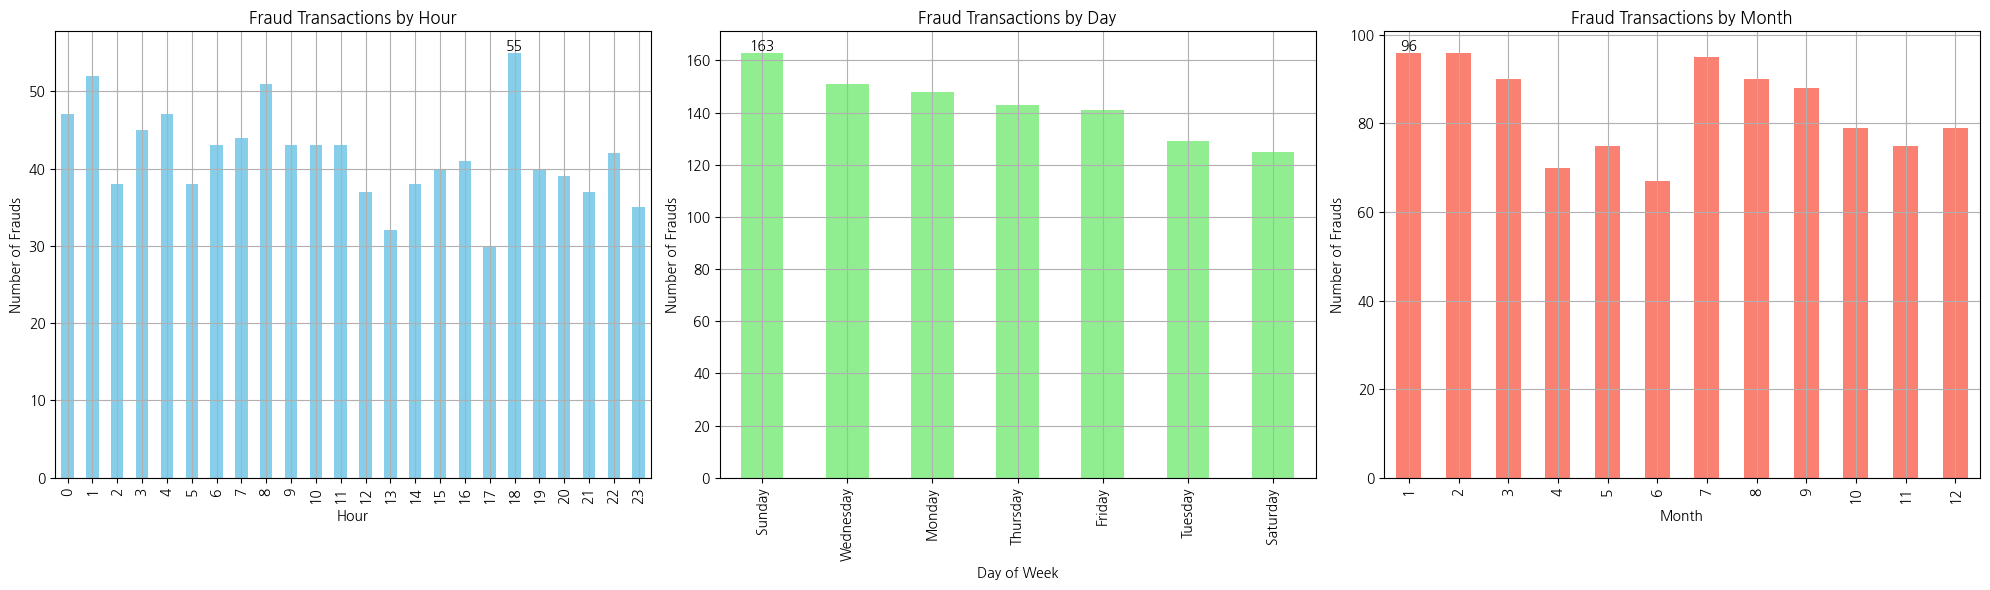

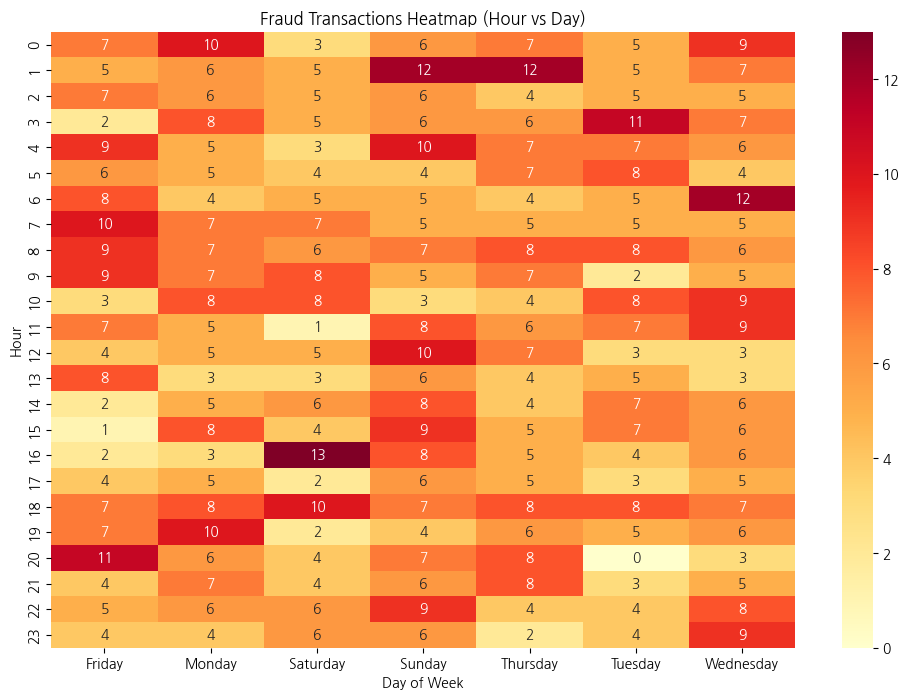

In [258]:
import matplotlib.pyplot as plt
import seaborn as sns

# 서브플롯 설정
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# 1. 시간별 사기 거래 시각화
fraudByHour.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Fraud Transactions by Hour')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Number of Frauds')
ax1.grid(True)

# 최대값 표시
ax1.text(peakHour, peakCount, f'{peakCount}', 
         ha='center', va='bottom')

# 2. 요일별 사기 거래 시각화
fraudByDay.plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Fraud Transactions by Day')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Number of Frauds')
ax2.grid(True)

# 최대값 표시
max_day = fraudByDay.max()
max_day_idx = fraudByDay.idxmax()
ax2.text(fraudByDay.index.get_loc(max_day_idx), max_day, 
         f'{max_day}', ha='center', va='bottom')

# 3. 월별 사기 거래 시각화
fraudByMonth.plot(kind='bar', ax=ax3, color='salmon')
ax3.set_title('Fraud Transactions by Month')
ax3.set_xlabel('Month')
ax3.set_ylabel('Number of Frauds')
ax3.grid(True)

# 최대값 표시
max_month = fraudByMonth.max()
max_month_idx = fraudByMonth.idxmax()
ax3.text(fraudByMonth.index.get_loc(max_month_idx), max_month, 
         f'{max_month}', ha='center', va='bottom')

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

# 히트맵으로 시간대와 요일의 관계 시각화
pivot_table = pd.crosstab(
    pd.to_datetime(fraud['TransactionDate']).dt.hour,
    pd.to_datetime(fraud['TransactionDate']).dt.day_name()
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='d')
plt.title('Fraud Transactions Heatmap (Hour vs Day)')
plt.xlabel('Day of Week')
plt.ylabel('Hour')
plt.show()
